# Natural Language Inference

This Jupyter Notebook fine-tunes `microsoft/mdeberta-v3-base` on the `Contradictory, My Dear Watson` dataset.
It includes data loading, preprocessing, data augmentation, model training, evaluation, and visualization.

### Environment setup

In [1]:
# Install dependencies
%pip install -q pandas numpy torch seaborn matplotlib scikit-learn transformers datasets nlpaug

Note: you may need to restart the kernel to use updated packages.


#### Import libraries

In [2]:
from pathlib import Path
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, concatenate_datasets

# Data augmentation
from nlpaug.augmenter.word import WordAugmenter, RandomWordAug, SynonymAug
from nlpaug.augmenter.char import KeyboardAug

In [3]:
ROOT_PATH = Path.cwd()
# Use fixed seed for results reproducibility
np.random.seed(0)

Little trick to prevent nltk downloading outputs:

In [4]:
def nltk_silent_download(*args, func=nltk.download, **kwargs):
    return func(*args, quiet=True, **kwargs)

nltk.download = nltk_silent_download

### Data loading

In [5]:
df = pd.read_csv(ROOT_PATH / "data/NLI_dataset.csv")  # Dataset path
df.sample(10)

,id,premise,hypothesis,lang_abv,language,label
6543,af77bed638,The experts point out that it is not age alone...,The Qin Dynasty has the most expensive antique...,en,English,1
9150,285d11dd62,Wear a nicely ventilated hat and keep to the s...,A sun umbrella might help those who really nee...,en,English,1
8245,00b1f84085,Each working group met several times to develo...,There were no meetings to discuss changes to t...,en,English,2
3753,e19376a801,farmworkers conducted by the U.S.,A labor survey also considered the views of ag...,en,English,1
713,b0afb96e00,كلمتا blood و flood ليس بنفس صوت food.,الغذاء هو بالضبط مثل الدم والفيضان.,ar,Arabic,2
2799,e33f803e46,"LSC set a deadline of October 1, 1998, for sub...",LSC set a deadline to submit state reports to ...,en,English,1
2335,45280f46e8,"Bila shaka, azimio lako lilikuwa la thamani, S...",Waspania walipanga kukutupa majini wakati wa u...,sw,Swahili,1
2397,0a9e0b89ab,"Eh! Monsieur Lawrence, called Poirot.",Poirot did not call upon Monsieur Lawrence.,en,English,2
3959,f093f8733c,Release 2.0: A Design for Living in the Digita...,Esther Dyson is the Author of Release 2.o: A D...,en,English,0
5808,49ba04c9a8,aCondition Assessment Survey (CAS).,CAS is a Condition Assessment Survey,en,English,0


Display label distribution: the dataset is evenly distributed across all labels.

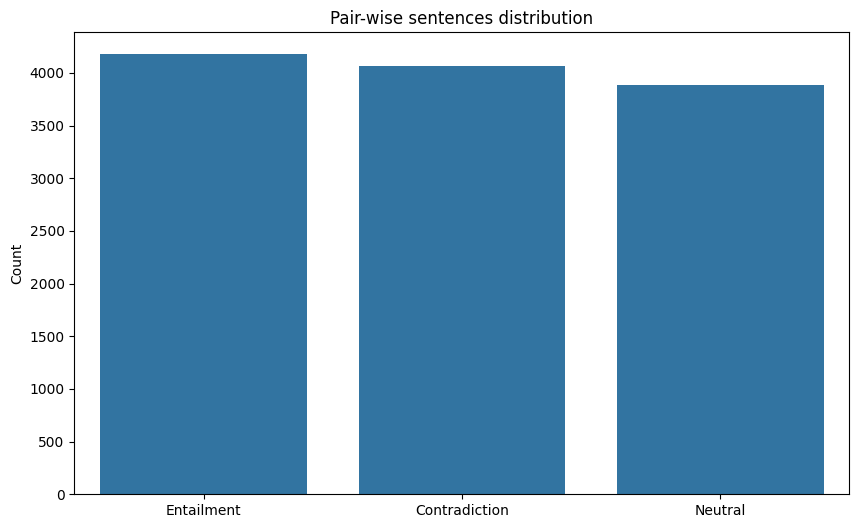

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df.label.replace({0: "Entailment", 1: "Neutral", 2: "Contradiction"}))
plt.xlabel(None)
plt.ylabel("Count")
plt.title("Pair-wise sentences distribution")
plt.show()

However, the dataset predominantly consists of English sentences.

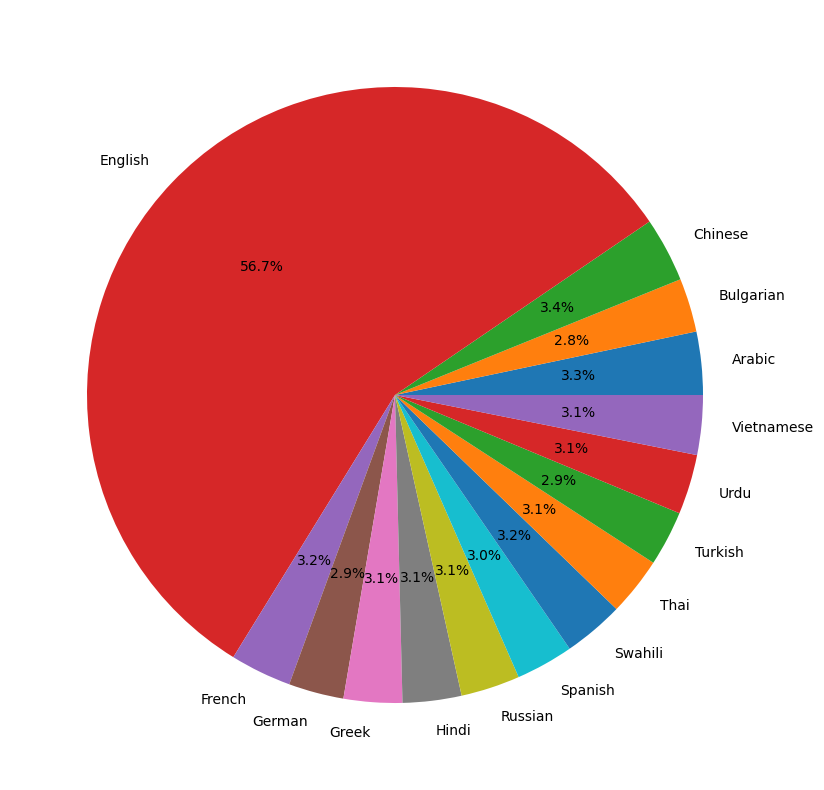

In [7]:
labels, frequencies = np.unique(df.language.values, return_counts = True)

plt.figure(figsize = (10, 10))
plt.pie(frequencies, labels=labels, autopct='%1.1f%%')
plt.show()

### Data Augmentation

Use `NLPAug` library to augment the data by using synonyms, typo insertion and word swapping.

In [8]:
def augment_text(text, augmenter):
    try:
        result = augmenter.augment(text)
        # Handle list outputs from some augmenters
        return result[0] if isinstance(result, list) else str(result)
    except Exception as e:
        return str(text)  # Ensure string return

def augment_df(df, augmenters, sample_frac=0.5):
    sample = df.sample(frac=sample_frac)
    augmented = []

    for _, row in tqdm(sample.iterrows(), total=len(sample)):
        for aug, weight in augmenters:
            if np.random.random() > weight:
                continue  # Skip this augmentation

            new_row = row.copy()
            premise = new_row['premise'] = augment_text(row['premise'], aug)
            hypothesis = new_row['hypothesis'] = augment_text(row['hypothesis'], aug)
            if premise != row["premise"] or hypothesis != row["hypothesis"]:
                augmented.append(new_row)

    return pd.DataFrame(augmented).convert_dtypes()

Define augmentation strategies and their probability to be used for each sentence.

In [9]:
augmenters = [
    (SynonymAug(aug_src='wordnet', aug_p=0.1), 0.8),   # Synonym replacement
    (RandomWordAug(action='swap', aug_p=0.1), 0.1),    # Word swapping
    (KeyboardAug(aug_char_p=0.1, aug_word_p=0.1), 0.3) # Typo simulation
]

df_aug = augment_df(df, augmenters)
print(f"Adding {len(df_aug)} new examples")

  0%|          | 0/6060 [00:00<?, ?it/s]

Adding 2344 new examples


### Model configuration

**Architecture:**  
- `microsoft/mdeberta-v3-base` transformer from HuggingFace
- Classification head with dropout (0.3)

**Training Parameters:**
- Batch size: 8 (train), 8 (eval)
- Learning rate: 2e-5
- Epochs: 5
- Weight decay: 0.01
- Warmup ratio: 0.1

Train using the `Trainer` API.

#### Define the model

In [10]:
MODEL_NAME = "microsoft/mdeberta-v3-base"

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
model.classifier.dropout = torch.nn.Dropout(0.3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

#### Tokenization

In [11]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/mdeberta-v3-base")

def tokenize_function(row):
    return tokenizer(
        row['premise'],
        row['hypothesis'],
        truncation=True,
        padding='max_length',
        max_length=256
    )

# Dataset tokenized
dataset = Dataset.from_pandas(df).map(tokenize_function, batched=True)
dataset_aug = Dataset.from_pandas(df_aug).map(tokenize_function, batched=True)

/home/adrien/Documents/TPS/2A/NLI/.venv/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/12120 [00:00<?, ? examples/s]

Map:   0%|          | 0/2344 [00:00<?, ? examples/s]

#### Train-test split:
- **Test set** is sampled from original dataset
- **Train set** is a concatenation of the sampled train part with augmented data

In [12]:
# Train-test split
split_set = dataset.train_test_split(test_size=0.2, seed=0)
train_set = concatenate_datasets([split_set['train'], dataset_aug])
test_set = split_set['test']

#### Training hyperparameters

In [13]:
model_path = ROOT_PATH / f"models/{MODEL_NAME.rpartition('/')[-1]}"

training_args = TrainingArguments(
    output_dir=model_path,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='none'  # Disabling wandb callbacks
)

def compute_metrics(pred):
    y_pred = np.argmax(pred.predictions, axis=1)
    return {'accuracy': accuracy_score(pred.label_ids, y_pred)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/home/adrien/Documents/TPS/2A/NLI/.venv/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_403767/1258284267.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Training

In [ ]:
trainer.train()

Save the best model and the tokenizer to disk.

In [ ]:
# Save the best model
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)
print(f"Model saved to {model_path}")

### Evaluation & Visualization

Compute accuracy on the test set.

In [ ]:
pred = trainer.predict(test_set)
y_true = test_set['label']
y_pred = np.argmax(pred.predictions, axis=-1)
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.3f}")

Display the confusion matrix using `seaborn`.

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Entailment', 'Neutral', 'Contradiction'],
            yticklabels=['Entailment', 'Neutral', 'Contradiction'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Entailment', 'Neutral', 'Contradiction']))